## UK-USA Analysis

This includes:
    - NERC, MRC, EPSRC, TSRC

In [1]:
import numpy as np
import pandas as pd
import scipy.spatial
import re
import gensim
from nltk.corpus import stopwords
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import Label
from bokeh.io import output_notebook
from pprint import pprint
import seaborn as sns

Load data

In [13]:
dictionary = gensim.corpora.Dictionary.load('../flavia/clean-data/fine-scale/UK-USA/dictionary.dict')
corpus = gensim.corpora.MmCorpus('../flavia/clean-data/fine-scale/UK-USA/corpus.mm')
lda = gensim.models.ldamulticore.LdaMulticore.load('../results/fine-scale/UK-USA/lda-models/model_134_topics')

Get topic words

In [14]:
#sns.set(rc={'figure.figsize':(15,15)})

topic_words = [[j[0] for j in lda.show_topic(i,topn = 15)] for i in range(lda.num_topics)]

topic_df = pd.DataFrame(topic_words)

print(topic_df.to_string())

# len(corpus)

                        0                  1                    2                      3                 4                  5                   6                       7                      8                        9                     10                   11                   12              13                     14
0                 survivor         prediction           cerebellum              predictor              risk             hazard              cancer               precision             estimation              probability              purkinje           melanocyte              infancy    survivorship                    arc
1               plasticity           collagen            cartilage               synapsis            matrix                mir            fracture                  mirnas                synapse                      bmp            biogenesis                 cell                spine           mirna          reprogramming
2                  support    inst

Get tsne dataframe and wrangle data

In [11]:
#load dataframe
tsne_df = pd.read_csv("../results/fine-scale/all-countries/tsne_full_df.csv")

#pivot perplexity
per_list = [30, 50, 70, 90, 110, 200]

for i in per_list:
    tsne_df[str(i)] = tsne_df["tsne_ax1_"+str(i)].astype("str") + " " +tsne_df["tsne_ax2_"+str(i)].astype("str")
    
cols = ["tsne_ax1_"+str(i) for i in per_list] + ["tsne_ax2_"+str(i) for i in per_list]

tsne_df = tsne_df.drop(columns=cols).melt(id_vars = tsne_df.columns[1:12], value_vars = map(str, per_list))

tsne_df[["ax1","ax2"]] = tsne_df.value.str.split(" ", expand = True).astype("float32")

tsne_df = tsne_df.assign(Imperial = tsne_df.LeadInstitution == "Imperial College London")

tsne_df = tsne_df.assign(UKRI = tsne_df.CountryFundingBody == "UKRI")

russell_group = pd.Series(["University of Birmingham", "University of Bristol", "University of Cambridge", "Cardiff University", "Durham University", "University of Edinburgh", "University of Exeter", 
"University of Glasgow", "Imperial College London", "King's College London", "University of Leeds", "University of Liverpool", "London School of Economics and Political Science", 
"University of Manchester", "Newcastle University", "University of Nottingham", "University of Oxford", "Queen Mary University of London", "Queen’s University Belfast", "University of Sheffield", 
"University of Southampton", "University College London", "University of Warwick", "University of York"])

tsne_df["RussellGroup"] = tsne_df["LeadInstitution"].isin(russell_group)

#add max_topics
#read doc_topic
doc_topic = np.load("../results/fine-scale/all-countries/doc_topic_mat.npy")
#get max topic
topic_max_vec = np.argmax(doc_topic, axis = (0))

tsne_df["Topic"] = topic_max_vec[tsne_df.CorpusId]


tsne_df = tsne_df.query("variable == '110'") 
tsne_df.count()

/var/folders/wv/tv9tdvts6m9fg377j70xphym0000gn/T/ipykernel_26599/1799270422.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  tsne_df = pd.read_csv("../results/fine-scale/all-countries/tsne_full_df.csv")


ProjectId             273621
Country               273621
CountryFundingBody    273621
CorpusId              273621
index                 273621
FundingBody           273621
LeadInstitution       273621
StartDate             273621
EndDate               273617
FundingAmount         273598
FundingCurrency       273621
variable              273621
value                 273621
ax1                   273621
ax2                   273621
Imperial              273621
UKRI                  273621
RussellGroup          273621
Topic                 273621
dtype: int64

In [12]:
tsne_df.columns

Index(['ProjectId', 'Country', 'CountryFundingBody', 'CorpusId', 'index',
       'FundingBody', 'LeadInstitution', 'StartDate', 'EndDate',
       'FundingAmount', 'FundingCurrency', 'variable', 'value', 'ax1', 'ax2',
       'Imperial', 'UKRI', 'RussellGroup', 'Topic'],
      dtype='object')

Look at top topics

In [24]:
imperial = tsne_df.groupby(['Imperial', 'Topic']).size().reset_index().sort_values([0], ascending=False).groupby(['Imperial']).head(10)
imperial.query("Imperial == True")

,Imperial,Topic,0
210,True,105,205
169,True,55,122
222,True,122,122
202,True,95,103
140,True,16,100
212,True,107,93
188,True,79,92
136,True,11,73
205,True,99,72
163,True,46,65


Look at the least topics

In [25]:
tsne_df.groupby(['Imperial', 'Topic']).size().reset_index().sort_values([0], ascending=False).groupby(['Imperial']).tail(10)

,Imperial,Topic,0
70,False,80,39
41,False,49,39
89,False,100,36
52,False,61,35
60,False,69,28
92,False,103,23
27,False,32,23
113,False,124,19
32,False,38,17
107,False,118,4


In [ ]:
topic_centers = tsne_df.query("variable == '110'").query("Imperial == False").groupby("Topic").agg(x = ("ax1","median"), y = ("ax2","median"))

sns.kdeplot(x = "ax1", y = "ax2", 
                data = tsne_df.query("variable == '110'"),
                color = "grey",
                levels = 8,
                alpha = 0.5,
                fill = True)

lim = 150
fig = plt.figure()

plt.axis([-lim,lim,-lim,lim])
for i in range(topic_centers.shape[0]):
    plt.text(topic_centers.x.iloc[i], topic_centers.y.iloc[i], topic_centers.index[i])


Show topics in tsne space first

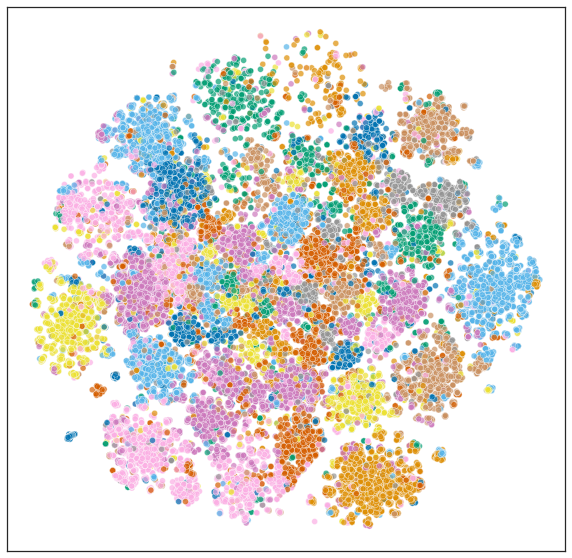

In [39]:
# all topics plotted in tsne space for the UK

sns.set(rc={'figure.figsize':(10,10)})

sns.set_theme(style="ticks", font_scale=2.0)

g = sns.scatterplot(x = "ax1", y = "ax2", 
                data = tsne_df.query("Country == 'UK'"),
                hue = "Topic",
                palette = "colorblind",
                alpha = 0.7)

g.set(xticklabels=[], yticklabels=[], xlabel=None, ylabel = None)
g.tick_params(bottom = False, left = False)

g.legend_.remove()

plt.savefig('../results/fine-scale/presentation_08.09.22/tsne_UK_topics.png')

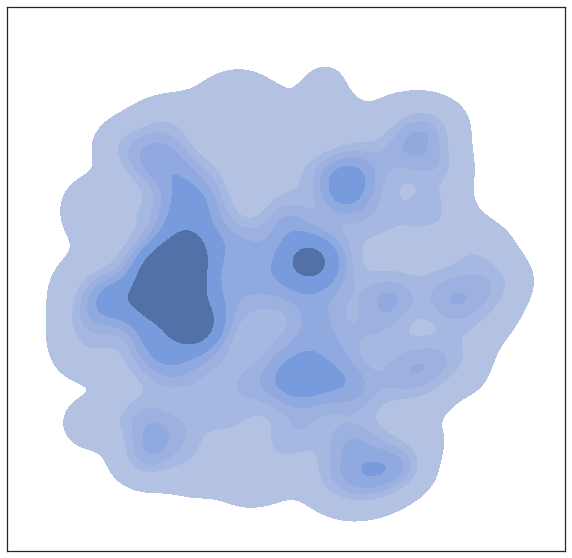

In [40]:
# all topics plotted in tsne space for the UK

sns.set(rc={'figure.figsize':(10,10)})

sns.set_theme(style="ticks", font_scale=2.0)

g = sns.kdeplot(x = "ax1", y = "ax2", 
                data = tsne_df.query("Country == 'UK'"),
                levels = 7,
                thresh=.01,
                fill=True)

g.set(xticklabels=[], yticklabels=[], xlabel=None, ylabel = None)
g.tick_params(bottom = False, left = False)

plt.savefig('../results/fine-scale/presentation_08.09.22/density_UK_topics.png')

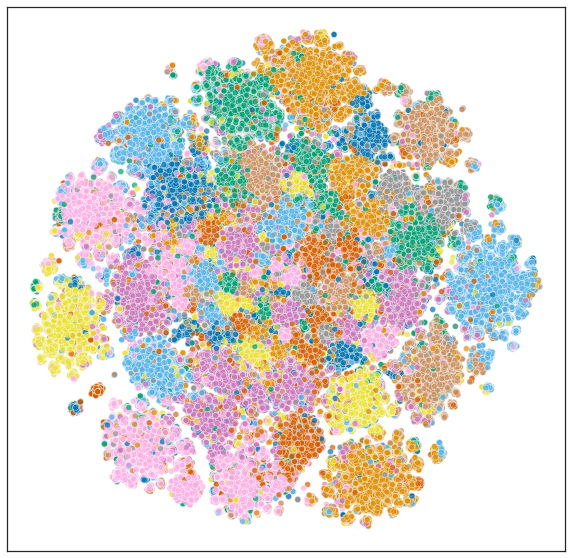

In [41]:
# all topics plotted in tsne space for the US

sns.set(rc={'figure.figsize':(10,10)})

sns.set_theme(style="ticks", font_scale=2.0)

g = sns.scatterplot(x = "ax1", y = "ax2", 
                data = tsne_df.query("Country == 'USA'"),
                hue = "Topic",
                palette = "colorblind",
                alpha = 0.7)

g.set(xticklabels=[], yticklabels=[], xlabel=None, ylabel = None)
g.tick_params(bottom = False, left = False)

g.legend_.remove()

plt.savefig('../results/fine-scale/presentation_08.09.22/tsne_US_topics.png')

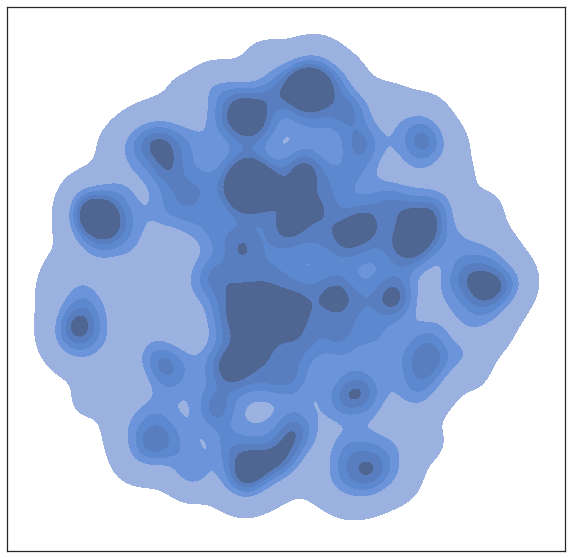

In [52]:
sns.set(rc={'figure.figsize':(10,10)})

sns.set_theme(style="ticks", font_scale=2.0)

g = sns.kdeplot(x = "ax1", y = "ax2", 
                data = tsne_df.query("Country == 'USA'"),
                levels = 6,
                thresh=.01,
                fill=True)

g.set(xticklabels=[], yticklabels=[], xlabel=None, ylabel = None)
g.tick_params(bottom = False, left = False)

plt.savefig('../results/fine-scale/presentation_08.09.22/density_US_topics.png')

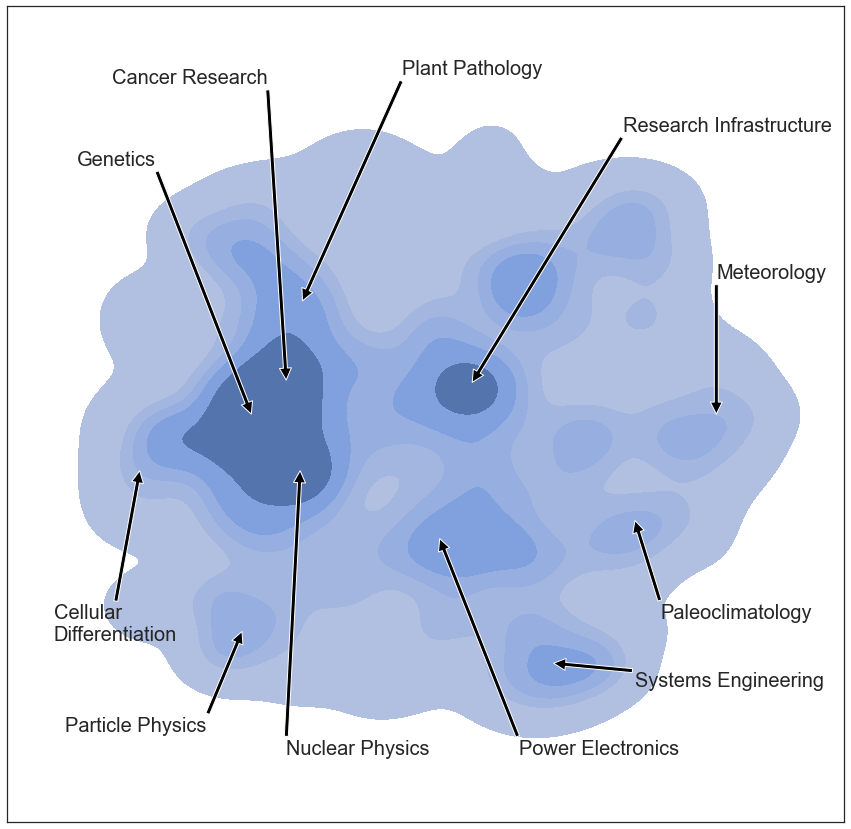

In [232]:
# all topics plotted in tsne space for the UK - ANNOTATED!

sns.set(rc={'figure.figsize':(15,15)})

sns.set_theme(style="ticks", font_scale=2.0)

# topic_centers = topic_centers = tsne_df.query("Country == 'UK'").groupby("Topic").agg(x = ("ax1","median"), y = ("ax2","median"), number=("Topic","count")).sort_values("number",ascending=False) 


# for i in range(30):
#     plt.text(topic_centers.x.iloc[i], topic_centers.y.iloc[i], topic_centers.index[i])
    
    
g = sns.kdeplot(x = "ax1", y = "ax2", 
                data = tsne_df.query("Country == 'UK'"),
                levels = 6,
                thresh=.01,
                fill=True)

# top 5 UK and USA
g.annotate("Meteorology", xy=(125,0), xytext=(125,60), fontsize= 20,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Systems Engineering", xy=(55,-110), xytext=(90,-120), fontsize= 20,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Cellular\nDifferentiation", xy=(-123,-25), xytext=(-160,-100), fontsize= 20,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
# g.annotate("Cellular\nDifferentiation", xy=(-115,-25), xytext=(-160,-100), fontsize= 20,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Particle Physics", xy=(-79,-96), xytext=(-155,-140), fontsize= 20,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Paleoclimatology", xy=(90,-47), xytext=(101,-90), fontsize= 20,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))

# top 5 UK
g.annotate("Genetics", xy=(-75,0), xytext=(-150,110), fontsize= 20,arrowprops=dict(facecolor='black',connectionstyle="arc3,rad=0"))
g.annotate("Research Infrastructure", xy=(20,14), xytext=(85,125), fontsize= 20,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Cancer Research", xy=(-60,15), xytext=(-135,146), fontsize= 20,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Nuclear Physics", xy=(-54,-25), xytext=(-60,-150), fontsize= 20,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Plant Pathology", xy=(-53,50), xytext=(-10,150), fontsize= 20,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))

g.annotate("Power Electronics", xy=(6,-55), xytext=(40,-150), fontsize= 20,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))

g.set_xlim(-180, 180)
g.set_ylim(-180, 180)

g.set(xticklabels=[], yticklabels=[], xlabel=None, ylabel = None)
g.tick_params(bottom = False, left = False)

plt.savefig('../results/fine-scale/presentation_08.09.22/density_UK_topics_annotated.png')

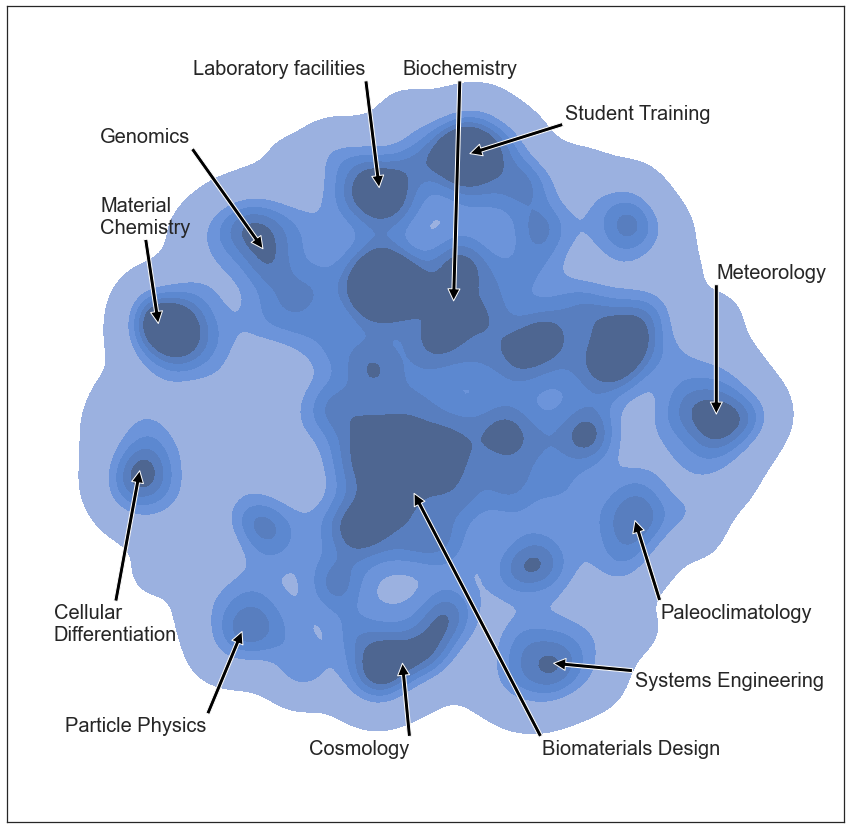

In [233]:
sns.set(rc={'figure.figsize':(15,15)})

sns.set_theme(style="ticks", font_scale=2.0)

# topic_centers = topic_centers = tsne_df.query("Country == 'USA'").groupby("Topic").agg(x = ("ax1","median"), y = ("ax2","median"), number=("Topic","count")).sort_values("number",ascending=False) 


# for i in range(25):
#     plt.text(topic_centers.x.iloc[i], topic_centers.y.iloc[i], topic_centers.index[i])


g = sns.kdeplot(x = "ax1", y = "ax2", 
                data = tsne_df.query("Country == 'USA'"),
                levels = 6,
                thresh=.01,
                fill=True
               )

# top 5 UK and USA
g.annotate("Meteorology", xy=(125,0), xytext=(125,60), fontsize= 20,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Systems Engineering", xy=(55,-110), xytext=(90,-120), fontsize= 20,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Cellular\nDifferentiation", xy=(-123,-25), xytext=(-160,-100), fontsize= 20,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Particle Physics", xy=(-79,-96), xytext=(-155,-140), fontsize= 20,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Paleoclimatology", xy=(90,-47), xytext=(101,-90), fontsize= 20,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))

# top 5 USA
g.annotate("Student Training", xy=(19,115), xytext=(60,130), fontsize= 20,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Material\nChemistry", xy=(-115,40), xytext=(-140,80), fontsize= 20,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Laboratory facilities", xy=(-20,100), xytext=(-100,150), fontsize= 20,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Cosmology", xy=(-10,-110), xytext=(-50,-150), fontsize= 20,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Genomics", xy=(-70,73), xytext=(-140,120), fontsize= 20,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))

# two topics in the top 25 USA
g.annotate("Biomaterials Design", xy=(-5,-35), xytext=(50,-150), fontsize= 20,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Biochemistry", xy=(12,50), xytext=(-10,150), fontsize= 20,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))

g.set_xlim(-180, 180)
g.set_ylim(-180, 180)

g.set(xticklabels=[], yticklabels=[], xlabel=None, ylabel = None)
g.tick_params(bottom = False, left = False)

plt.savefig('../results/fine-scale/presentation_08.09.22/density_US_topics_annotated.png')

In [104]:
tsne_df.head()

,ProjectId,Country,CountryFundingBody,CorpusId,index,FundingBody,LeadInstitution,StartDate,EndDate,FundingAmount,FundingCurrency,variable,value,ax1,ax2,Imperial,UKRI,RussellGroup,Topic
1094484,C863601C-4645-4020-914E-3C572106BB23,UK,UKRI,0,14139,MRC,University of Oxford,30/04/2013,29/04/2016,1274897.0,GBP,110,-62.331676 19.59747,-62.331676,19.597469,False,True,True,81
1094485,C1B1FA74-D748-451F-A74C-9EDE41BF7EE3,UK,UKRI,1,45356,BBSRC,The James Hutton Institute,30/09/2012,30/03/2016,115747.0,GBP,110,-42.04772 66.540886,-42.047722,66.540886,False,True,False,89
1094486,73CCF222-0616-4CE8-8BFD-8738EBED8513,UK,UKRI,2,34003,EPSRC,University of Southampton,10/01/2011,09/01/2015,916817.0,GBP,110,-7.9740887 -48.668095,-7.974089,-48.668095,False,True,True,95
1094487,D2FDCD7F-77ED-4434-ACAC-2419E5232F14,UK,UKRI,3,39368,EPSRC,University of Edinburgh,31/08/2009,30/08/2010,86434.0,GBP,110,10.093515 -103.5654,10.093515,-103.565399,False,True,True,94
1094488,17555E0B-B1D0-45E3-ABBC-568398B51F03,UK,UKRI,4,31117,MRC,London Sch of Hygiene and Trop Medicine,26/01/2015,30/03/2017,50405.0,GBP,110,17.384256 9.571398,17.384256,9.571398,False,True,False,65


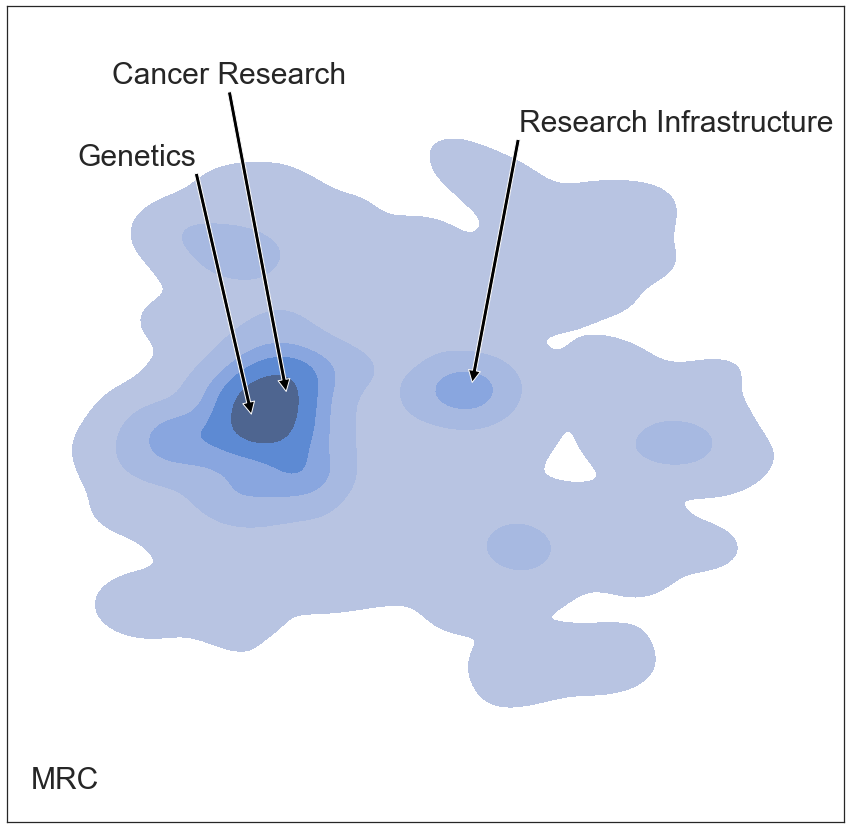

In [126]:
sns.set(rc={'figure.figsize':(15,15)})

sns.set_theme(style="ticks", font_scale=2.0)

# topic_centers = topic_centers = tsne_df.query("FundingBody == 'MRC'").groupby("Topic").agg(x = ("ax1","median"), y = ("ax2","median"), number=("Topic","count")).sort_values("number",ascending=False) 


# for i in range(25):
#     plt.text(topic_centers.x.iloc[i], topic_centers.y.iloc[i], topic_centers.index[i])


g = sns.kdeplot(x = "ax1", y = "ax2", 
                data = tsne_df.query("FundingBody == 'MRC'"),
                levels = 6,
                thresh=.01,
                fill=True
               )

# top 5 UK
g.annotate("Genetics", xy=(-75,0), xytext=(-150,110), fontsize= 30,arrowprops=dict(facecolor='black',connectionstyle="arc3,rad=0"))
g.annotate("Research Infrastructure", xy=(20,14), xytext=(40,125), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Cancer Research", xy=(-60,10), xytext=(-135,146), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))

# research council
g.annotate("MRC", xy=(-170,-165), fontsize= 30)

g.set_xlim(-180, 180)
g.set_ylim(-180, 180)

g.set(xticklabels=[], yticklabels=[], xlabel=None, ylabel = None)
g.tick_params(bottom = False, left = False)

plt.savefig('../results/fine-scale/presentation_08.09.22/density_BBSRC_topics_annotated.png')

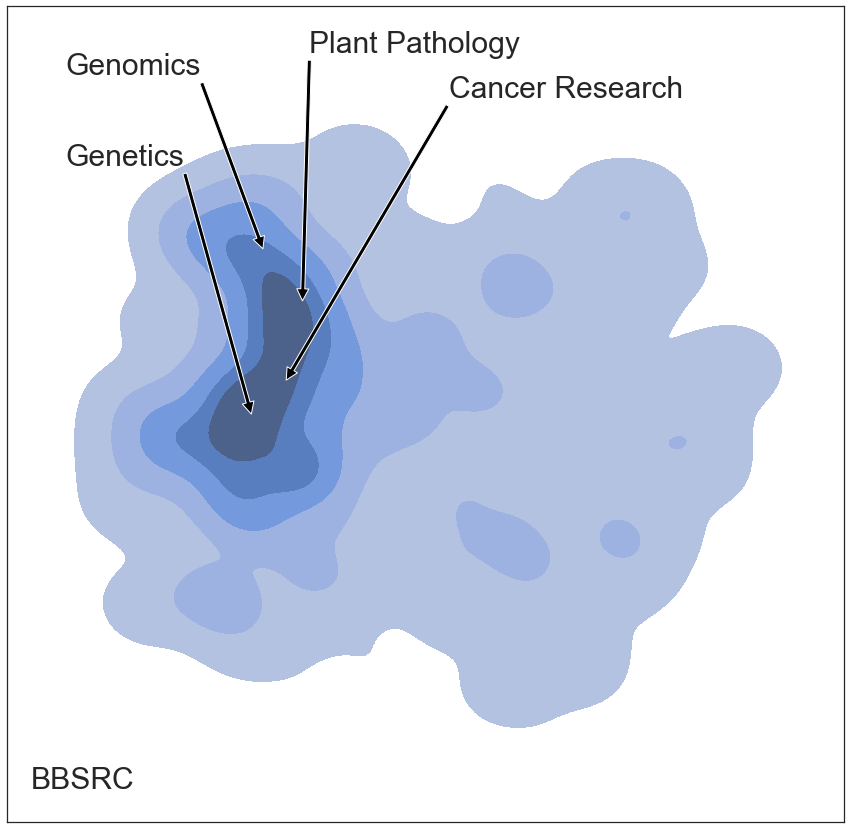

In [271]:
sns.set(rc={'figure.figsize':(15,15)})

sns.set_theme(style="ticks", font_scale=2.0)

# topic_centers = topic_centers = tsne_df.query("FundingBody == 'BBSRC'").groupby("Topic").agg(x = ("ax1","median"), y = ("ax2","median"), number=("Topic","count")).sort_values("number",ascending=False) 


# for i in range(25):
#     plt.text(topic_centers.x.iloc[i], topic_centers.y.iloc[i], topic_centers.index[i])


g = sns.kdeplot(x = "ax1", y = "ax2", 
                data = tsne_df.query("FundingBody == 'BBSRC'"),
                levels = 6,
                thresh=.01,
                fill=True
               )
g.annotate("Plant Pathology", xy=(-53,50), xytext=(-50,160), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Genomics", xy=(-70,73), xytext=(-155,150), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Genetics", xy=(-75,0), xytext=(-155,110), fontsize= 30,arrowprops=dict(facecolor='black',connectionstyle="arc3,rad=0"))
g.annotate("Cancer Research", xy=(-60,15), xytext=(10,140), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))

# research council
g.annotate("BBSRC", xy=(-170,-165), fontsize= 30)

g.set_xlim(-180, 180)
g.set_ylim(-180, 180)

g.set(xticklabels=[], yticklabels=[], xlabel=None, ylabel = None)
g.tick_params(bottom = False, left = False)

plt.savefig('../results/fine-scale/presentation_08.09.22/density_BBSRC_topics_annotated.png')

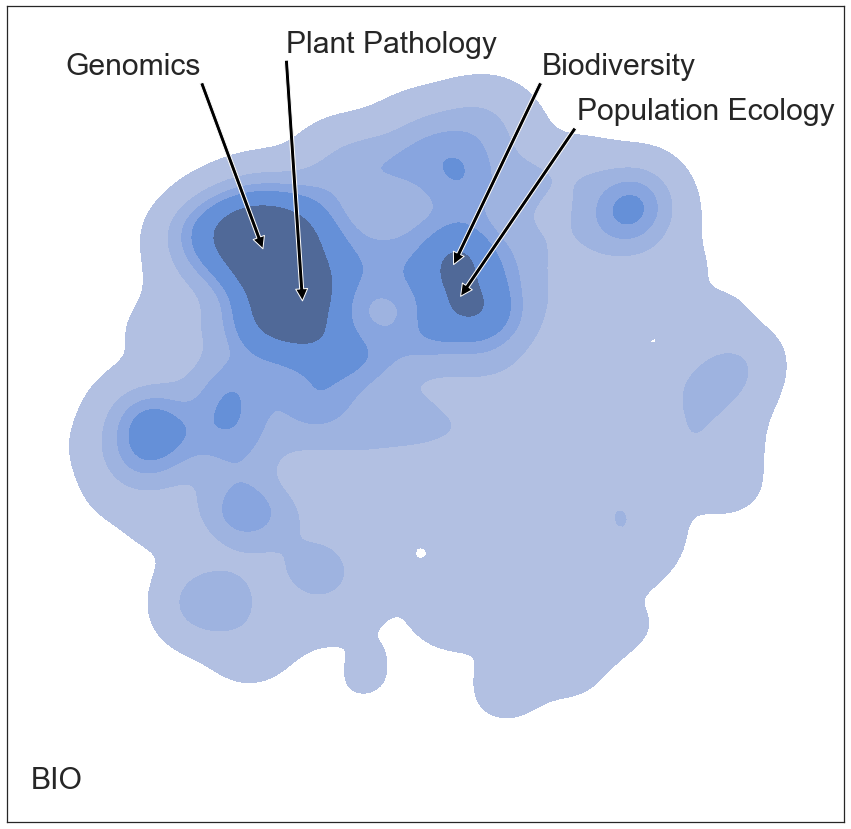

In [270]:
sns.set(rc={'figure.figsize':(15,15)})

sns.set_theme(style="ticks", font_scale=2.0)

# topic_centers = topic_centers = tsne_df.query("FundingBody == 'BIO'").groupby("Topic").agg(x = ("ax1","median"), y = ("ax2","median"), number=("Topic","count")).sort_values("number",ascending=False) 


# for i in range(25):
#     plt.text(topic_centers.x.iloc[i], topic_centers.y.iloc[i], topic_centers.index[i])


g = sns.kdeplot(x = "ax1", y = "ax2", 
                data = tsne_df.query("FundingBody == 'BIO'"),
                levels = 6,
                thresh=.01,
                fill=True
               )


g.annotate("Genomics", xy=(-70,73), xytext=(-155,150), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Plant Pathology", xy=(-53,50), xytext=(-60,160), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Population Ecology", xy=(15,52), xytext=(65,130), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Biodiversity", xy=(12,66), xytext=(50,150), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))

# research council
g.annotate("BIO", xy=(-170,-165), fontsize= 30)

g.set_xlim(-180, 180)
g.set_ylim(-180, 180)

g.set(xticklabels=[], yticklabels=[], xlabel=None, ylabel = None)
g.tick_params(bottom = False, left = False)

plt.savefig('../results/fine-scale/presentation_08.09.22/density_BIO_topics_annotated.png')

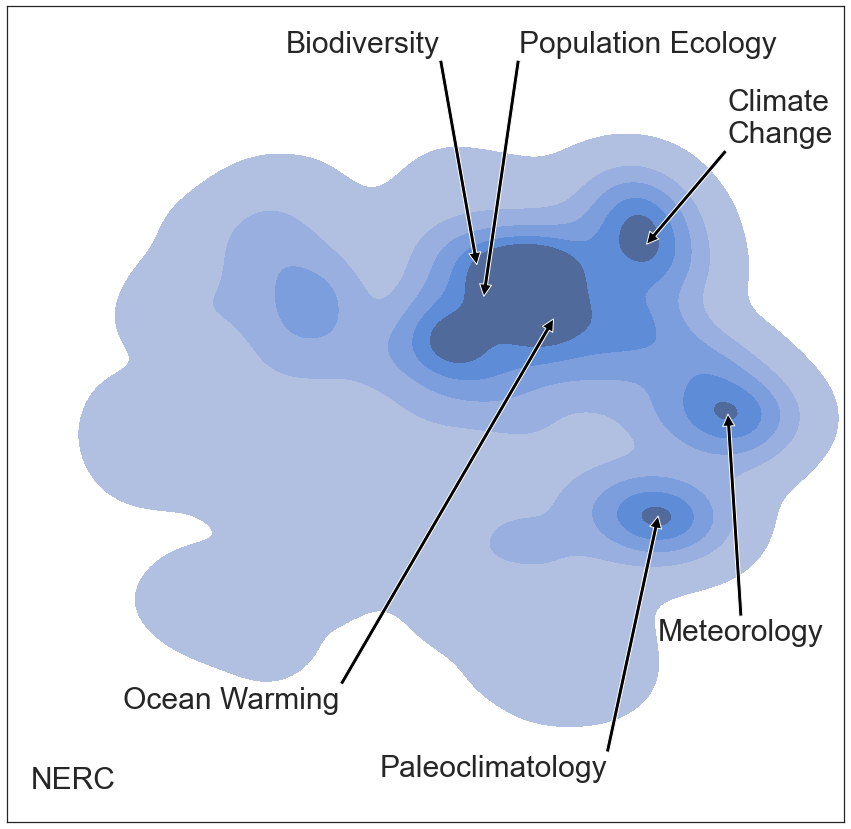

In [236]:
sns.set(rc={'figure.figsize':(15,15)})

sns.set_theme(style="ticks", font_scale=2.0)

# topic_centers = topic_centers = tsne_df.query("FundingBody == 'NERC'").groupby("Topic").agg(x = ("ax1","median"), y = ("ax2","median"), number=("Topic","count")).sort_values("number",ascending=False) 


# for i in range(25):
#     plt.text(topic_centers.x.iloc[i], topic_centers.y.iloc[i], topic_centers.index[i])


g = sns.kdeplot(x = "ax1", y = "ax2", 
                data = tsne_df.query("FundingBody == 'NERC'"),
                levels = 6,
                thresh=.01,
                fill=True
               )




g.annotate("Population Ecology", xy=(25,52), xytext=(40,160), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Biodiversity", xy=(22,66), xytext=(-60,160), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Meteorology", xy=(130,0), xytext=(100,-100), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Paleoclimatology", xy=(100,-45), xytext=(-20,-160), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Climate\nChange", xy=(95,75), xytext=(130,120), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Ocean Warming", xy=(55,42), xytext=(-130,-130), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))


# research council
g.annotate("NERC", xy=(-170,-165), fontsize= 30)

g.set_xlim(-180, 180)
g.set_ylim(-180, 180)

g.set(xticklabels=[], yticklabels=[], xlabel=None, ylabel = None)
g.tick_params(bottom = False, left = False)

plt.savefig('../results/fine-scale/presentation_08.09.22/density_NERC_topics_annotated.png')

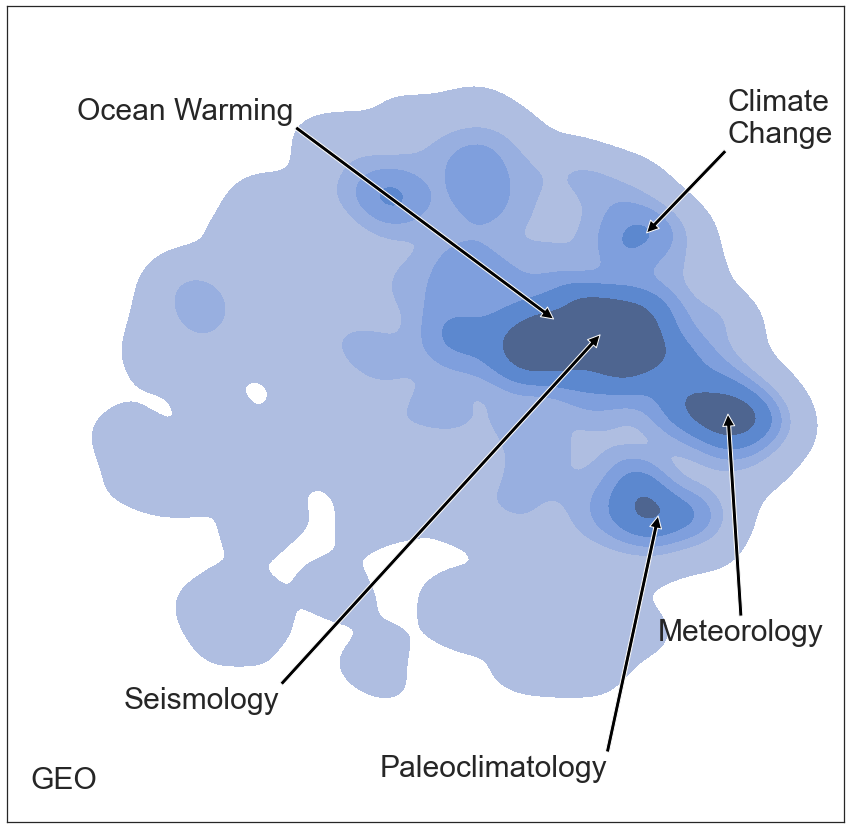

In [237]:
sns.set(rc={'figure.figsize':(15,15)})

sns.set_theme(style="ticks", font_scale=2.0)

# topic_centers = topic_centers = tsne_df.query("FundingBody == 'GEO'").groupby("Topic").agg(x = ("ax1","median"), y = ("ax2","median"), number=("Topic","count")).sort_values("number",ascending=False) 


# for i in range(25):
#     plt.text(topic_centers.x.iloc[i], topic_centers.y.iloc[i], topic_centers.index[i])


g = sns.kdeplot(x = "ax1", y = "ax2", 
                data = tsne_df.query("FundingBody == 'GEO'"),
                levels = 6,
                thresh=.01,
                fill=True
               )


g.annotate("Meteorology", xy=(130,0), xytext=(100,-100), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Paleoclimatology", xy=(100,-45), xytext=(-20,-160), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Climate\nChange", xy=(95,80), xytext=(130,120), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Ocean Warming", xy=(55,42), xytext=(-150,130), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Seismology", xy=(75,35), xytext=(-130,-130), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))


# research council
g.annotate("GEO", xy=(-170,-165), fontsize= 30)

g.set_xlim(-180, 180)
g.set_ylim(-180, 180)

g.set(xticklabels=[], yticklabels=[], xlabel=None, ylabel = None)
g.tick_params(bottom = False, left = False)

# plt.savefig('../results/fine-scale/presentation_08.09.22/density_GEO_topics_annotated.png')

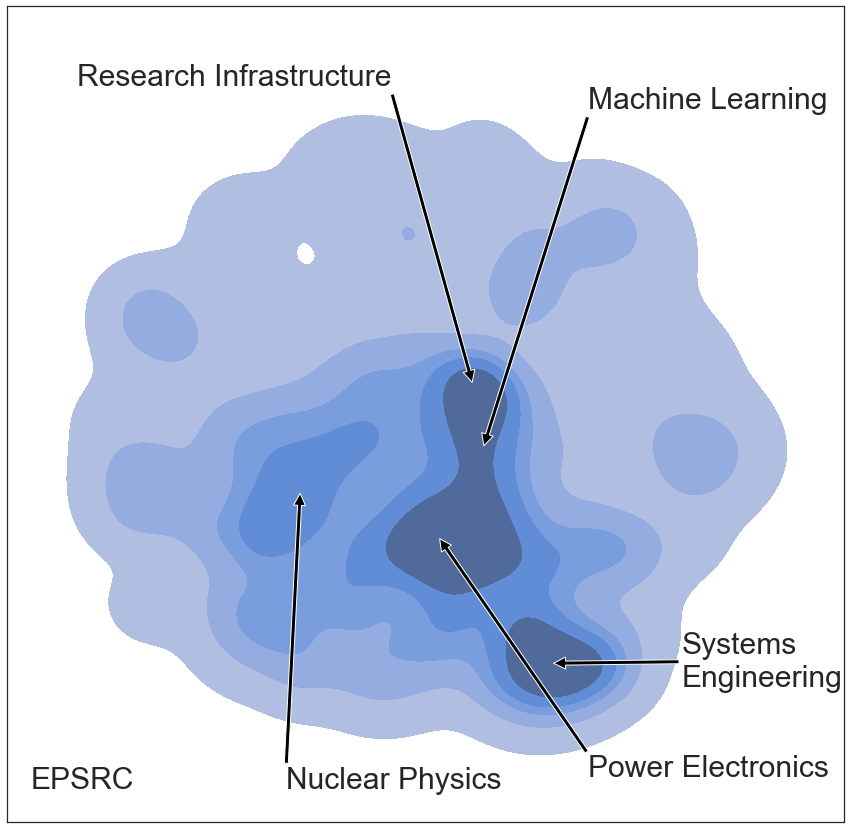

In [202]:
sns.set(rc={'figure.figsize':(15,15)})

sns.set_theme(style="ticks", font_scale=2.0)

# topic_centers = topic_centers = tsne_df.query("FundingBody == 'EPSRC'").groupby("Topic").agg(x = ("ax1","median"), y = ("ax2","median"), number=("Topic","count")).sort_values("number",ascending=False) 


# for i in range(25):
#     plt.text(topic_centers.x.iloc[i], topic_centers.y.iloc[i], topic_centers.index[i])


g = sns.kdeplot(x = "ax1", y = "ax2", 
                data = tsne_df.query("FundingBody == 'EPSRC'"),
                levels = 6,
                thresh=.01,
                fill=True
               )

g.annotate("Systems\nEngineering", xy=(55,-110), xytext=(110,-120), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Research Infrastructure", xy=(20,14), xytext=(-150,145), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Nuclear Physics", xy=(-54,-35), xytext=(-60,-165), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Power Electronics", xy=(6,-55), xytext=(70,-160), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Machine Learning", xy=(25,-14), xytext=(70,135), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))

# research council
g.annotate("EPSRC", xy=(-170,-165), fontsize= 30)

g.set_xlim(-180, 180)
g.set_ylim(-180, 180)

g.set(xticklabels=[], yticklabels=[], xlabel=None, ylabel = None)
g.tick_params(bottom = False, left = False)

# plt.savefig('../results/fine-scale/presentation_08.09.22/density_EPSRC_topics_annotated.png')

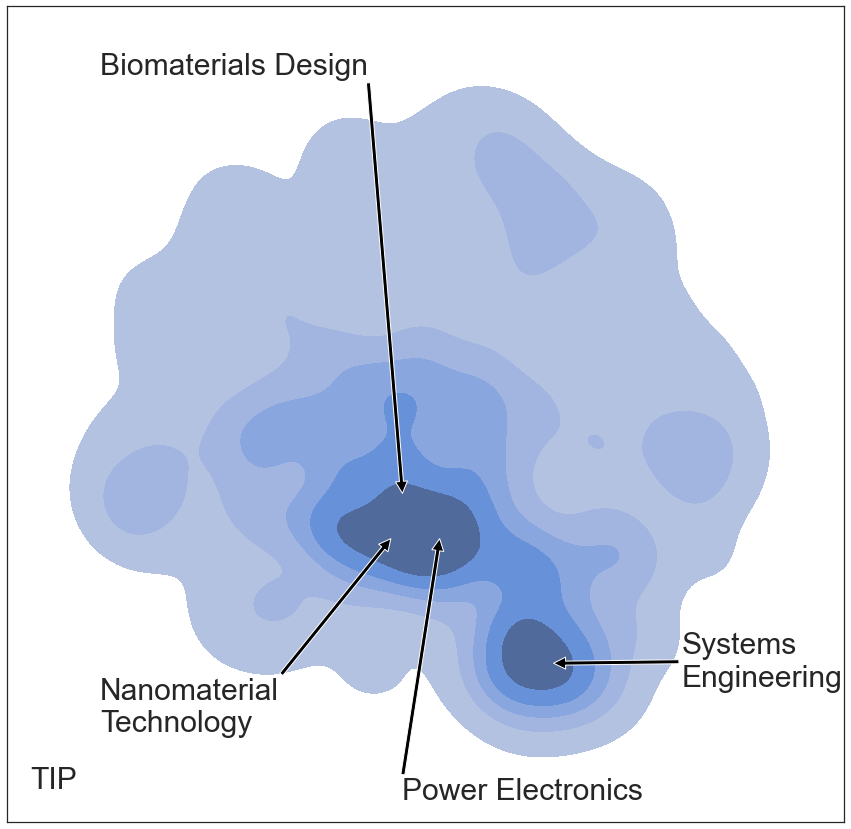

In [211]:
sns.set(rc={'figure.figsize':(15,15)})

sns.set_theme(style="ticks", font_scale=2.0)

# topic_centers = topic_centers = tsne_df.query("FundingBody == 'TIP'").groupby("Topic").agg(x = ("ax1","median"), y = ("ax2","median"), number=("Topic","count")).sort_values("number",ascending=False) 


# for i in range(25):
#     plt.text(topic_centers.x.iloc[i], topic_centers.y.iloc[i], topic_centers.index[i])


g = sns.kdeplot(x = "ax1", y = "ax2", 
                data = tsne_df.query("FundingBody == 'TIP'"),
                levels = 6,
                thresh=.01,
                fill=True
               )

g.annotate("Systems\nEngineering", xy=(55,-110), xytext=(110,-120), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Power Electronics", xy=(6,-55), xytext=(-10,-170), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Biomaterials Design", xy=(-10,-35), xytext=(-140,150), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Nanomaterial\nTechnology", xy=(-15,-55), xytext=(-140,-140), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))

# research council
g.annotate("TIP", xy=(-170,-165), fontsize= 30)

g.set_xlim(-180, 180)
g.set_ylim(-180, 180)

g.set(xticklabels=[], yticklabels=[], xlabel=None, ylabel = None)
g.tick_params(bottom = False, left = False)

plt.savefig('../results/fine-scale/presentation_08.09.22/density_TIP_topics_annotated.png')

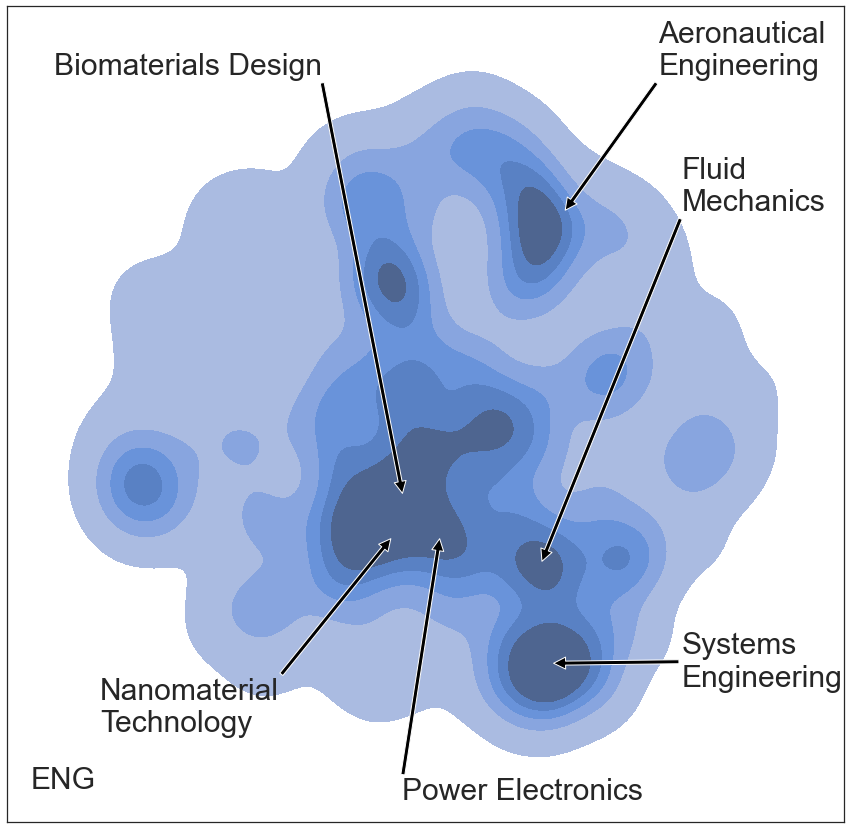

In [216]:
sns.set(rc={'figure.figsize':(15,15)})

sns.set_theme(style="ticks", font_scale=2.0)

# topic_centers = topic_centers = tsne_df.query("FundingBody == 'ENG'").groupby("Topic").agg(x = ("ax1","median"), y = ("ax2","median"), number=("Topic","count")).sort_values("number",ascending=False) 


# for i in range(25):
#     plt.text(topic_centers.x.iloc[i], topic_centers.y.iloc[i], topic_centers.index[i])


g = sns.kdeplot(x = "ax1", y = "ax2", 
                data = tsne_df.query("FundingBody == 'ENG'"),
                levels = 6,
                thresh=.01,
                fill=True
               )

g.annotate("Systems\nEngineering", xy=(55,-110), xytext=(110,-120), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Power Electronics", xy=(6,-55), xytext=(-10,-170), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Biomaterials Design", xy=(-10,-35), xytext=(-160,150), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Nanomaterial\nTechnology", xy=(-15,-55), xytext=(-140,-140), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Aeronautical\nEngineering", xy=(60,90), xytext=(100,150), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Fluid\nMechanics", xy=(50,-65), xytext=(110,90), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))

# research council
g.annotate("ENG", xy=(-170,-165), fontsize= 30)

g.set_xlim(-180, 180)
g.set_ylim(-180, 180)

g.set(xticklabels=[], yticklabels=[], xlabel=None, ylabel = None)
g.tick_params(bottom = False, left = False)

plt.savefig('../results/fine-scale/presentation_08.09.22/density_ENG_topics_annotated.png')

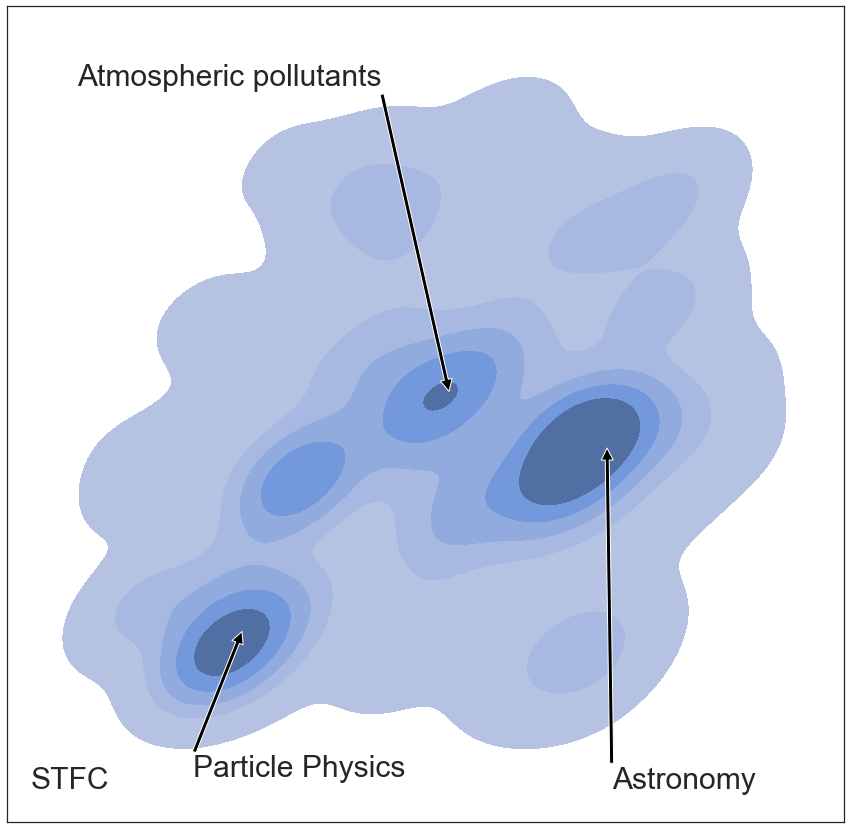

In [273]:
sns.set(rc={'figure.figsize':(15,15)})

sns.set_theme(style="ticks", font_scale=2.0)

# topic_centers = topic_centers = tsne_df.query("FundingBody == 'STFC'").groupby("Topic").agg(x = ("ax1","median"), y = ("ax2","median"), number=("Topic","count")).sort_values("number",ascending=False) 


# for i in range(25):
#     plt.text(topic_centers.x.iloc[i], topic_centers.y.iloc[i], topic_centers.index[i])


g = sns.kdeplot(x = "ax1", y = "ax2", 
                data = tsne_df.query("FundingBody == 'STFC'"),
                levels = 6,
                thresh=.01,
                fill=True
               )

g.annotate("Particle Physics", xy=(-79,-96), xytext=(-100,-160), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Atmospheric pollutants", xy=(10,10), xytext=(-150,145), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Astronomy", xy=(78,-15), xytext=(80,-165), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))

# research council
g.annotate("STFC", xy=(-170,-165), fontsize= 30)

g.set_xlim(-180, 180)
g.set_ylim(-180, 180)

g.set(xticklabels=[], yticklabels=[], xlabel=None, ylabel = None)
g.tick_params(bottom = False, left = False)

plt.savefig('../results/fine-scale/presentation_08.09.22/density_STFC_topics_annotated.png')

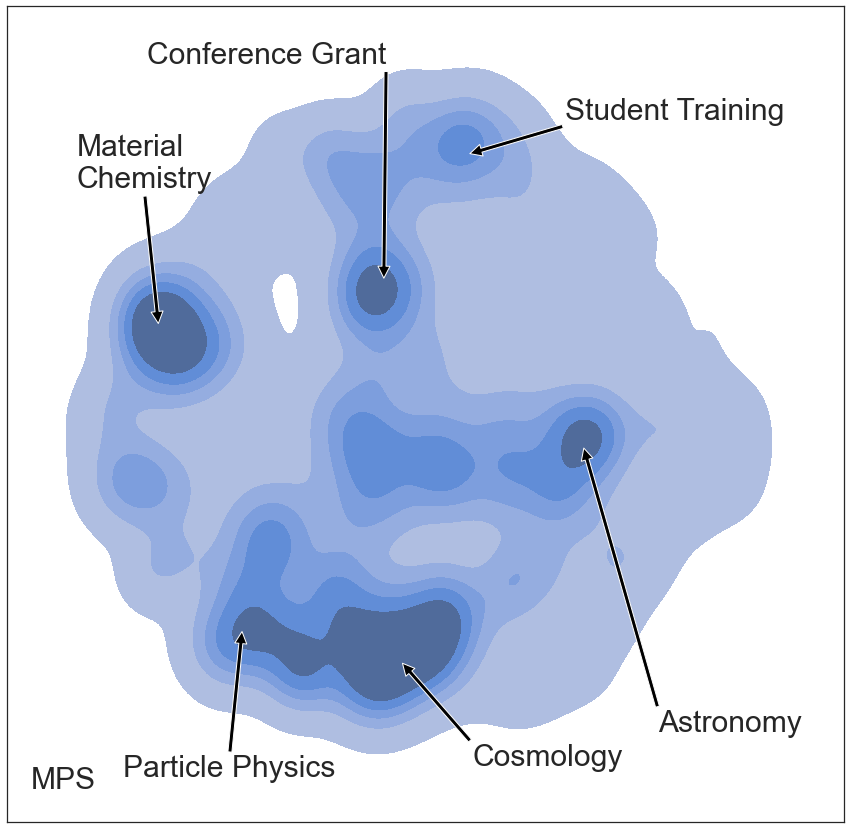

In [272]:
sns.set(rc={'figure.figsize':(15,15)})

sns.set_theme(style="ticks", font_scale=2.0)

# topic_centers = topic_centers = tsne_df.query("FundingBody == 'MPS'").groupby("Topic").agg(x = ("ax1","median"), y = ("ax2","median"), number=("Topic","count")).sort_values("number",ascending=False) 


# for i in range(25):
#     plt.text(topic_centers.x.iloc[i], topic_centers.y.iloc[i], topic_centers.index[i])


g = sns.kdeplot(x = "ax1", y = "ax2", 
                data = tsne_df.query("FundingBody == 'MPS'"),
                levels = 6,
                thresh=.01,
                fill=True
               )

g.annotate("Particle Physics", xy=(-79,-96), xytext=(-130,-160), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Astronomy", xy=(68,-15), xytext=(100,-140), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Student Training", xy=(19,115), xytext=(60,130), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Material\nChemistry", xy=(-115,40), xytext=(-150,100), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Cosmology", xy=(-10,-110), xytext=(20,-155), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Conference Grant", xy=(-18,60), xytext=(-120,155), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))


# research council
g.annotate("MPS", xy=(-170,-165), fontsize= 30)

g.set_xlim(-180, 180)
g.set_ylim(-180, 180)

g.set(xticklabels=[], yticklabels=[], xlabel=None, ylabel = None)
g.tick_params(bottom = False, left = False)

plt.savefig('../results/fine-scale/presentation_08.09.22/density_MPS_topics_annotated.png')

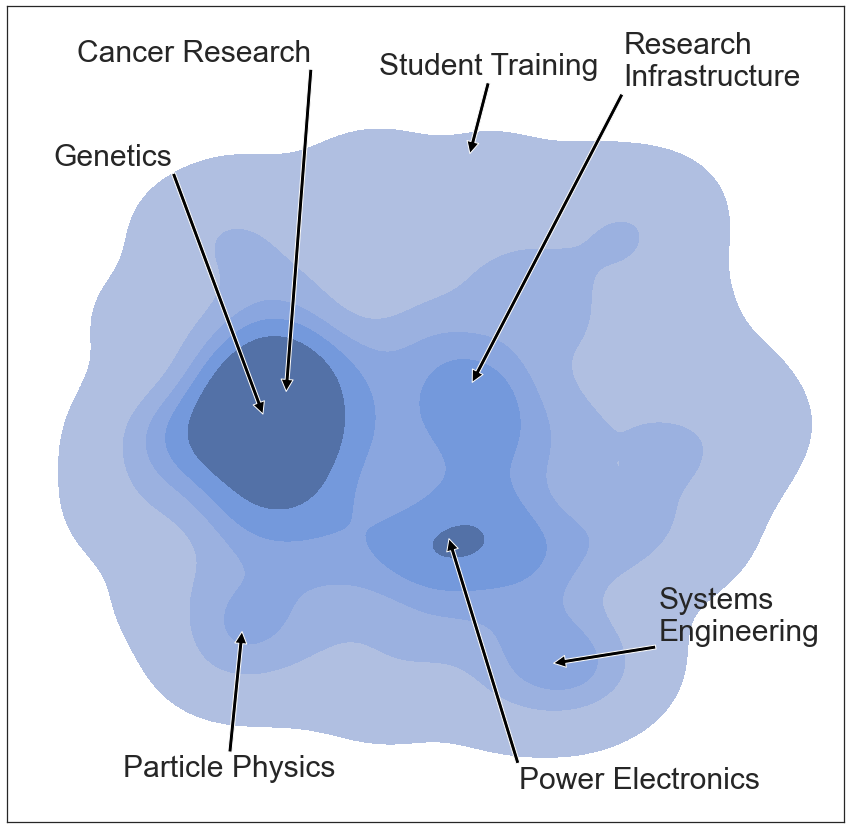

In [282]:
# all topics plotted in tsne space for Imperial - ANNOTATED!

sns.set(rc={'figure.figsize':(15,15)})

sns.set_theme(style="ticks", font_scale=2.0)

# topic_centers = topic_centers = tsne_df.query("Imperial == True").groupby("Topic").agg(x = ("ax1","median"), y = ("ax2","median"), number=("Topic","count")).sort_values("number",ascending=False) 


# for i in range(25):
#     plt.text(topic_centers.x.iloc[i], topic_centers.y.iloc[i], topic_centers.index[i])
    
    
g = sns.kdeplot(x = "ax1", y = "ax2", 
                data = tsne_df.query("Imperial == True"),
                color = sns.color_palette()[0],
                levels = 6,
                thresh=.01,
                fill=True
                # hue = "Topic",
                # palette = "colorblind",
                # color =sns.color_palette()[0],
                # alpha = 0.7,
                   )

g.annotate("Genetics", xy=(-70,0), xytext=(-160,110), fontsize= 30,arrowprops=dict(facecolor='black',connectionstyle="arc3,rad=0"))
g.annotate("Cancer Research", xy=(-60,10), xytext=(-150,156), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Systems\nEngineering", xy=(55,-110), xytext=(100,-100), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Power Electronics", xy=(10,-55), xytext=(40,-165), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Particle Physics", xy=(-79,-96), xytext=(-130,-160), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Research\nInfrastructure", xy=(20,14), xytext=(85,145), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Student Training", xy=(19,115), xytext=(-20,150), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))


g.set_xlim(-180, 180)
g.set_ylim(-180, 180)

g.set(xticklabels=[], yticklabels=[], xlabel=None, ylabel = None)
g.tick_params(bottom = False, left = False)

plt.savefig('../results/fine-scale/presentation_08.09.22/density_Imperial_topics_annotated.png')

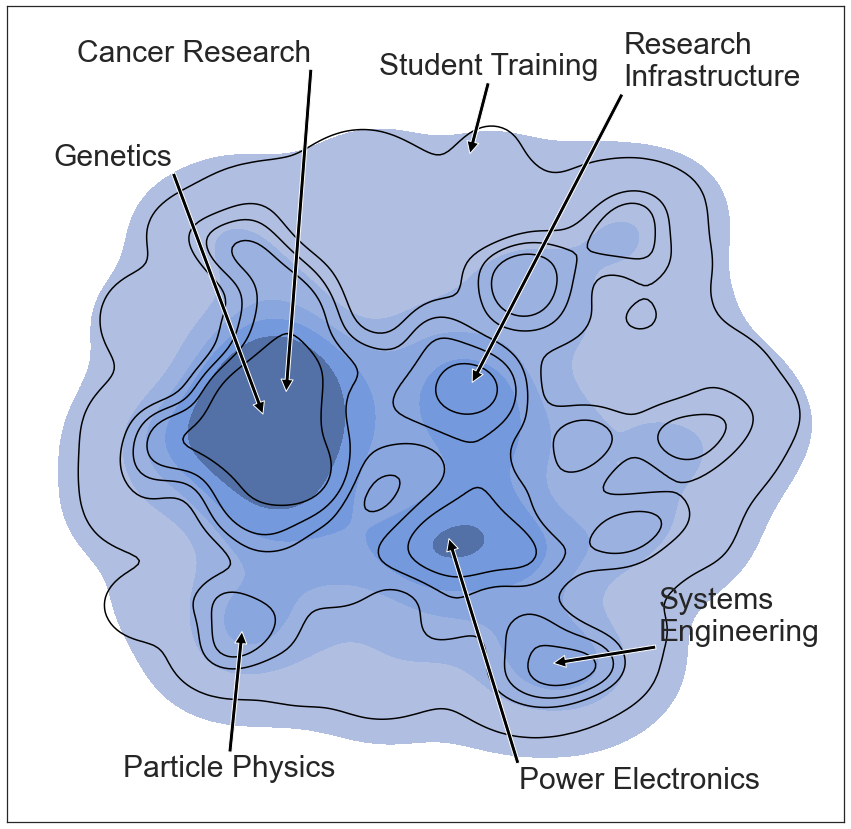

In [279]:
# all topics plotted in tsne space for Imperial - ANNOTATED!

sns.set(rc={'figure.figsize':(15,15)})

sns.set_theme(style="ticks", font_scale=2.0)

# topic_centers = topic_centers = tsne_df.query("Imperial == True").groupby("Topic").agg(x = ("ax1","median"), y = ("ax2","median"), number=("Topic","count")).sort_values("number",ascending=False) 


# for i in range(25):
#     plt.text(topic_centers.x.iloc[i], topic_centers.y.iloc[i], topic_centers.index[i])
    
    
g = sns.kdeplot(x = "ax1", y = "ax2", 
                data = tsne_df.query("Imperial == True"),
                color = sns.color_palette()[0],
                levels = 6,
                thresh=.01,
                fill=True
                # hue = "Topic",
                # palette = "colorblind",
                # color =sns.color_palette()[0],
                # alpha = 0.7,
                   )

g = sns.kdeplot(x = "ax1", y = "ax2", 
                data = tsne_df.query("Country == 'UK'"),
                color = "black",
                levels = 6,
                thresh=.01,
                alpha = 1,
                fill=False)


g.annotate("Genetics", xy=(-70,0), xytext=(-160,110), fontsize= 30,arrowprops=dict(facecolor='black',connectionstyle="arc3,rad=0"))
g.annotate("Cancer Research", xy=(-60,10), xytext=(-150,156), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Systems\nEngineering", xy=(55,-110), xytext=(100,-100), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Power Electronics", xy=(10,-55), xytext=(40,-165), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Particle Physics", xy=(-79,-96), xytext=(-130,-160), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Research\nInfrastructure", xy=(20,14), xytext=(85,145), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Student Training", xy=(19,115), xytext=(-20,150), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))


g.set_xlim(-180, 180)
g.set_ylim(-180, 180)

g.set(xticklabels=[], yticklabels=[], xlabel=None, ylabel = None)
g.tick_params(bottom = False, left = False)

plt.savefig('../results/fine-scale/presentation_08.09.22/density_Imperial_UK_topics_annotated.png')

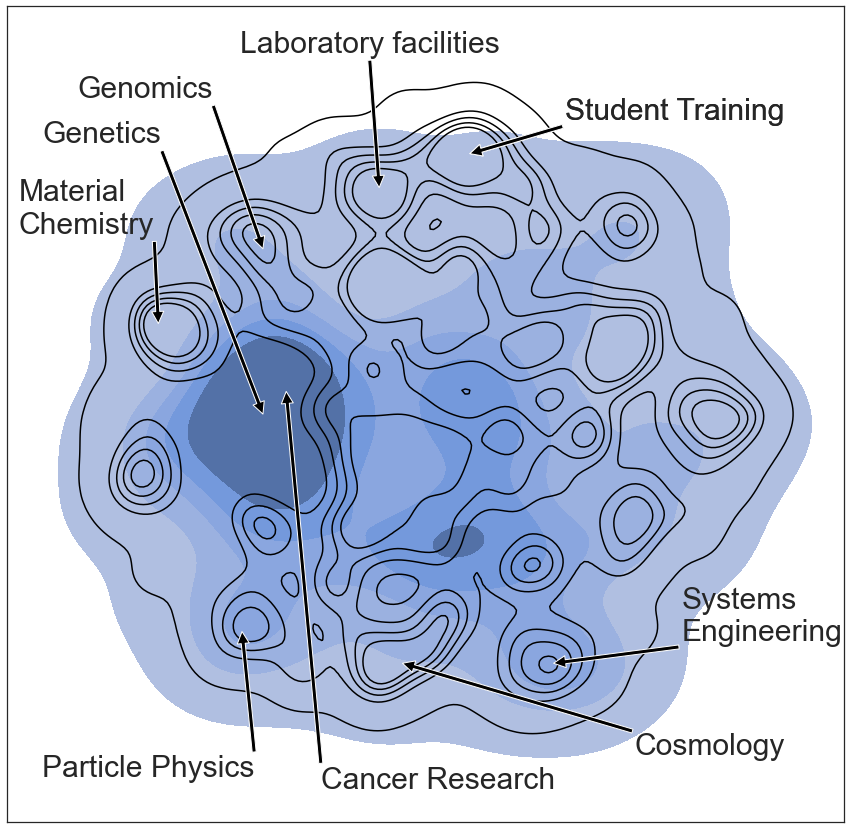

In [281]:
# all topics plotted in tsne space for Imperial - ANNOTATED!

sns.set(rc={'figure.figsize':(15,15)})

sns.set_theme(style="ticks", font_scale=2.0)

# topic_centers = topic_centers = tsne_df.query("Imperial == True").groupby("Topic").agg(x = ("ax1","median"), y = ("ax2","median"), number=("Topic","count")).sort_values("number",ascending=False) 


# for i in range(25):
#     plt.text(topic_centers.x.iloc[i], topic_centers.y.iloc[i], topic_centers.index[i])
    
    
g = sns.kdeplot(x = "ax1", y = "ax2", 
                data = tsne_df.query("Imperial == True"),
                color = sns.color_palette()[0],
                levels = 6,
                thresh=.01,
                fill=True
                # hue = "Topic",
                # palette = "colorblind",
                # color =sns.color_palette()[0],
                # alpha = 0.7,
                   )

g = sns.kdeplot(x = "ax1", y = "ax2", 
                data = tsne_df.query("Country == 'USA'"),
                color = "black",
                levels = 6,
                thresh=.01,
                alpha = 1,
                fill=False)

g.annotate("Genetics", xy=(-70,0), xytext=(-165,120), fontsize= 30,arrowprops=dict(facecolor='black',connectionstyle="arc3,rad=0"))
g.annotate("Cancer Research", xy=(-60,10), xytext=(-45,-165), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Systems\nEngineering", xy=(55,-110), xytext=(110,-100), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Particle Physics", xy=(-79,-96), xytext=(-165,-160), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Student Training", xy=(19,115), xytext=(60,130), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))

# top 5 USA
g.annotate("Student Training", xy=(19,115), xytext=(60,130), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Material\nChemistry", xy=(-115,40), xytext=(-175,80), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Laboratory facilities", xy=(-20,100), xytext=(-80,160), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Cosmology", xy=(-10,-110), xytext=(90,-150), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Genomics", xy=(-70,73), xytext=(-150,140), fontsize= 30,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))

g.set_xlim(-180, 180)
g.set_ylim(-180, 180)

g.set(xticklabels=[], yticklabels=[], xlabel=None, ylabel = None)
g.tick_params(bottom = False, left = False)

plt.savefig('../results/fine-scale/presentation_08.09.22/density_Imperial_USA_topics_annotated.png')